## Imports

In [0]:
!nvidia-smi

Fri Aug 23 12:24:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dense,Dropout,LeakyReLU
import keras.datasets as dsets
from keras import initializers
from keras.optimizers import Adam
import random
from keras import backend as K
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load Dataset


In [0]:
def load_mnist():
  (x_train,y_train) , (x_test,y_test) = dsets.mnist.load_data()
  
  x_train = (x_train.astype(np.float32) - 127.5 ) / 127.5
  
  x_train = x_train.reshape(x_train.shape[0],784)
  
  return (x_train,y_train,x_test,y_test)
    

## Generators & Discriminators

In [0]:
random_dim = 100
optimizer =  Adam(lr = 0.0002, beta_1 = 0.5)

In [0]:
def get_generator(optimizer):
  
  init  = initializers.RandomNormal(stddev = 0.02)
  
  g = Sequential()
  
  g.add(Dense(256,input_dim = random_dim,kernel_initializer=init ))
  g.add(LeakyReLU(alpha = 0.2))
  
  g.add(Dense(512))
  g.add(LeakyReLU(0.2))
  
  g.add(Dense(1024))
  g.add(LeakyReLU(0.2))
  
  g.add(Dense(784,activation='tanh'))
  g.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  return g

In [0]:
def get_discriminator(optimizer):
  
  init  = initializers.RandomNormal(stddev = 0.02)
  
  des = Sequential()
  des.add(Dense(1024,input_dim = 784 ,kernel_initializer= init ))
  des.add(LeakyReLU(0.2))
  des.add(Dropout(0.3))
  
  des.add(Dense(512))
  des.add(LeakyReLU(0.2))
  des.add(Dropout(0.3))
  
  des.add(Dense(256))
  des.add(LeakyReLU(0.2))
  des.add(Dropout(0.3))
  
  des.add(Dense(1,activation='sigmoid'))
  des.compile(loss = 'binary_crossentropy',optimizer=optimizer)
  
  return des
  

## GAN

In [0]:
def GAN(generator,descriminator,optimizer,random_dim):
  
  descriminator.trainable = False
  
  gan_input = Input(shape = (random_dim,))
  
  x= generator(gan_input)
  
  gan_output = descriminator(x)
  
  gan = Model(gan_input,gan_output)
  gan.compile(loss = 'binary_crossentropy' ,optimizer = optimizer)
  
  return gan

## Training

In [0]:
def plot_generated_images(epoch,generator,examples = 9, dim = (3,3),fig_size = (3,3) ):
  
  noise = np.random.normal(0,1,size = [examples , random_dim])
  
  gen_imgs = generator.predict(noise)
  
  gen_imgs = gen_imgs.reshape(examples,28,28)
  
  
  plt.figure(figsize=fig_size)
  for i in range(gen_imgs.shape[0]):
    plt.subplot(dim[0],dim[1],i+1)
    plt.imshow(gen_imgs[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('GAN_gntd_img_epoch{}'.format(epoch))

In [0]:
def train(epochs = 1, batch_size = 128):
  K.set_image_dim_ordering('th')
  x_train,y_train, x_test , y_test = load_mnist()
  
  batch_count = int(x_train.shape[0] / batch_size)
  
  generator = get_generator(optimizer)
  
  discriminator = get_discriminator(optimizer)
  
  
  gan = GAN(generator,discriminator,optimizer,random_dim)
  
  for e in range(1,epochs + 1):
    print('-'*15,'Epoch # %d' % e, '-'*15)
    
    for _ in tqdm( range(batch_count)):
      
      noise  = np.random.normal(0,1,size= [batch_size, random_dim])
      image_batch = x_train[np.random.randint(0,x_train.shape[0],size = batch_size)]
      
      fake_imgs = generator.predict(noise)
      X = np.concatenate([image_batch,fake_imgs])
      
      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9
      
      #Train D
      discriminator.trainable = True
      discriminator.train_on_batch(X,y_dis)
      
      #Train G
      noise = np.random.normal(0,1,size = [batch_size,random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable =False
      gan.train_on_batch(noise,y_gen)
      
    if e == 1  or e% 5 == 0:
      plot_generated_images(e,generator)


In [0]:
import time

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch # 1 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.44it/s]

--------------- Epoch # 2 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.57it/s]

--------------- Epoch # 3 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.75it/s]

--------------- Epoch # 4 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.64it/s]

--------------- Epoch # 5 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.89it/s]

--------------- Epoch # 6 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.38it/s]

--------------- Epoch # 7 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.41it/s]

--------------- Epoch # 8 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.90it/s]

--------------- Epoch # 9 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.41it/s]

--------------- Epoch # 10 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.74it/s]

--------------- Epoch # 11 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.10it/s]

--------------- Epoch # 12 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.92it/s]

--------------- Epoch # 13 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.63it/s]

--------------- Epoch # 14 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.58it/s]

--------------- Epoch # 15 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.82it/s]

--------------- Epoch # 16 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.41it/s]

--------------- Epoch # 17 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.22it/s]

--------------- Epoch # 18 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.83it/s]

--------------- Epoch # 19 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.52it/s]

--------------- Epoch # 20 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.96it/s]

--------------- Epoch # 21 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.14it/s]

--------------- Epoch # 22 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.26it/s]

--------------- Epoch # 23 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.11it/s]

--------------- Epoch # 24 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.03it/s]

--------------- Epoch # 25 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.58it/s]

--------------- Epoch # 26 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.47it/s]

--------------- Epoch # 27 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.01it/s]

--------------- Epoch # 28 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.18it/s]

--------------- Epoch # 29 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.56it/s]

--------------- Epoch # 30 ---------------


  1%|▏         | 6/468 [00:00<00:08, 57.41it/s]

--------------- Epoch # 31 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.50it/s]

--------------- Epoch # 32 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.47it/s]

--------------- Epoch # 33 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.38it/s]

--------------- Epoch # 34 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.77it/s]

--------------- Epoch # 35 ---------------


  1%|▏         | 6/468 [00:00<00:08, 53.67it/s]

--------------- Epoch # 36 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.05it/s]

--------------- Epoch # 37 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.62it/s]

--------------- Epoch # 38 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.07it/s]

--------------- Epoch # 39 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.28it/s]

--------------- Epoch # 40 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.09it/s]

--------------- Epoch # 41 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.81it/s]

--------------- Epoch # 42 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.00it/s]

--------------- Epoch # 43 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.59it/s]

--------------- Epoch # 44 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.69it/s]

--------------- Epoch # 45 ---------------


  1%|▏         | 6/468 [00:00<00:07, 58.22it/s]

--------------- Epoch # 46 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.71it/s]

--------------- Epoch # 47 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.42it/s]

--------------- Epoch # 48 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.36it/s]

--------------- Epoch # 49 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.62it/s]

--------------- Epoch # 50 ---------------


  1%|▏         | 6/468 [00:00<00:08, 56.27it/s]

--------------- Epoch # 51 ---------------


  2%|▏         | 8/468 [00:00<00:06, 69.53it/s]

--------------- Epoch # 52 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.40it/s]

--------------- Epoch # 53 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.63it/s]

--------------- Epoch # 54 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.61it/s]

--------------- Epoch # 55 ---------------


  1%|▏         | 6/468 [00:00<00:08, 56.88it/s]

--------------- Epoch # 56 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.52it/s]

--------------- Epoch # 57 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.28it/s]

--------------- Epoch # 58 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.72it/s]

--------------- Epoch # 59 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.16it/s]

--------------- Epoch # 60 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.32it/s]

--------------- Epoch # 61 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.90it/s]

--------------- Epoch # 62 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.95it/s]

--------------- Epoch # 63 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.47it/s]

--------------- Epoch # 64 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.56it/s]

--------------- Epoch # 65 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.66it/s]

--------------- Epoch # 66 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.27it/s]

--------------- Epoch # 67 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.60it/s]

--------------- Epoch # 68 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.53it/s]

--------------- Epoch # 69 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.74it/s]

--------------- Epoch # 70 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.99it/s]

--------------- Epoch # 71 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.40it/s]

--------------- Epoch # 72 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.78it/s]

--------------- Epoch # 73 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.14it/s]

--------------- Epoch # 74 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.79it/s]

--------------- Epoch # 75 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.09it/s]

--------------- Epoch # 76 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.44it/s]

--------------- Epoch # 77 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.81it/s]

--------------- Epoch # 78 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.08it/s]

--------------- Epoch # 79 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.90it/s]

--------------- Epoch # 80 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.28it/s]

--------------- Epoch # 81 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.50it/s]

--------------- Epoch # 82 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.27it/s]

--------------- Epoch # 83 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.11it/s]

--------------- Epoch # 84 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.58it/s]

--------------- Epoch # 85 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.32it/s]

--------------- Epoch # 86 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.07it/s]

--------------- Epoch # 87 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.10it/s]

--------------- Epoch # 88 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.62it/s]

--------------- Epoch # 89 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.45it/s]

--------------- Epoch # 90 ---------------


  1%|▏         | 6/468 [00:00<00:08, 57.71it/s]

--------------- Epoch # 91 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.76it/s]

--------------- Epoch # 92 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.99it/s]

--------------- Epoch # 93 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.38it/s]

--------------- Epoch # 94 ---------------


  1%|▏         | 6/468 [00:00<00:07, 58.00it/s]

--------------- Epoch # 95 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.09it/s]

--------------- Epoch # 96 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.48it/s]

--------------- Epoch # 97 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.81it/s]

--------------- Epoch # 98 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.48it/s]

--------------- Epoch # 99 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.05it/s]

--------------- Epoch # 100 ---------------


100%|██████████| 468/468 [00:06<00:00, 67.17it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  1%|▏         | 7/468 [00:00<00:07, 64.87it/s]

--------------- Epoch # 101 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.52it/s]

--------------- Epoch # 102 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.07it/s]

--------------- Epoch # 103 ---------------


  1%|▏         | 6/468 [00:00<00:08, 53.04it/s]

--------------- Epoch # 104 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.23it/s]

--------------- Epoch # 105 ---------------


  1%|▏         | 6/468 [00:00<00:08, 57.13it/s]

--------------- Epoch # 106 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.83it/s]

--------------- Epoch # 107 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.30it/s]

--------------- Epoch # 108 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.33it/s]

--------------- Epoch # 109 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.61it/s]

--------------- Epoch # 110 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.88it/s]

--------------- Epoch # 111 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.04it/s]

--------------- Epoch # 112 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.52it/s]

--------------- Epoch # 113 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.69it/s]

--------------- Epoch # 114 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.41it/s]

--------------- Epoch # 115 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.60it/s]

--------------- Epoch # 116 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.48it/s]

--------------- Epoch # 117 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.07it/s]

--------------- Epoch # 118 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.18it/s]

--------------- Epoch # 119 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.17it/s]

--------------- Epoch # 120 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.63it/s]

--------------- Epoch # 121 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.11it/s]

--------------- Epoch # 122 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.09it/s]

--------------- Epoch # 123 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.59it/s]

--------------- Epoch # 124 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.28it/s]

--------------- Epoch # 125 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.98it/s]

--------------- Epoch # 126 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.32it/s]

--------------- Epoch # 127 ---------------


  1%|▏         | 6/468 [00:00<00:08, 55.10it/s]

--------------- Epoch # 128 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.59it/s]

--------------- Epoch # 129 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.38it/s]

--------------- Epoch # 130 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.19it/s]

--------------- Epoch # 131 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.62it/s]

--------------- Epoch # 132 ---------------


  1%|▏         | 6/468 [00:00<00:08, 55.68it/s]

--------------- Epoch # 133 ---------------


  1%|▏         | 7/468 [00:00<00:06, 65.91it/s]

--------------- Epoch # 134 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.57it/s]

--------------- Epoch # 135 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.35it/s]

--------------- Epoch # 136 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.59it/s]

--------------- Epoch # 137 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.49it/s]

--------------- Epoch # 138 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.08it/s]

--------------- Epoch # 139 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.52it/s]

--------------- Epoch # 140 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.97it/s]

--------------- Epoch # 141 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.60it/s]

--------------- Epoch # 142 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.48it/s]

--------------- Epoch # 143 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.84it/s]

--------------- Epoch # 144 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.30it/s]

--------------- Epoch # 145 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.90it/s]

--------------- Epoch # 146 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.59it/s]

--------------- Epoch # 147 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.91it/s]

--------------- Epoch # 148 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.48it/s]

--------------- Epoch # 149 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.29it/s]

--------------- Epoch # 150 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.56it/s]

--------------- Epoch # 151 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.48it/s]

--------------- Epoch # 152 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.92it/s]

--------------- Epoch # 153 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.04it/s]

--------------- Epoch # 154 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.11it/s]

--------------- Epoch # 155 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.59it/s]

--------------- Epoch # 156 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.88it/s]

--------------- Epoch # 157 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.01it/s]

--------------- Epoch # 158 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.90it/s]

--------------- Epoch # 159 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.36it/s]

--------------- Epoch # 160 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.44it/s]

--------------- Epoch # 161 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.74it/s]

--------------- Epoch # 162 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.57it/s]

--------------- Epoch # 163 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.82it/s]

--------------- Epoch # 164 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.95it/s]

--------------- Epoch # 165 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.17it/s]

--------------- Epoch # 166 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.70it/s]

--------------- Epoch # 167 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.53it/s]

--------------- Epoch # 168 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.15it/s]

--------------- Epoch # 169 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.95it/s]

--------------- Epoch # 170 ---------------


  1%|▏         | 6/468 [00:00<00:08, 56.75it/s]

--------------- Epoch # 171 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.24it/s]

--------------- Epoch # 172 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.85it/s]

--------------- Epoch # 173 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.43it/s]

--------------- Epoch # 174 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.02it/s]

--------------- Epoch # 175 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.99it/s]

--------------- Epoch # 176 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.23it/s]

--------------- Epoch # 177 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.92it/s]

--------------- Epoch # 178 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.56it/s]

--------------- Epoch # 179 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.48it/s]

--------------- Epoch # 180 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.92it/s]

--------------- Epoch # 181 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.00it/s]

--------------- Epoch # 182 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.29it/s]

--------------- Epoch # 183 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.78it/s]

--------------- Epoch # 184 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.04it/s]

--------------- Epoch # 185 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.06it/s]

--------------- Epoch # 186 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.58it/s]

--------------- Epoch # 187 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.16it/s]

--------------- Epoch # 188 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.66it/s]

--------------- Epoch # 189 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.24it/s]

--------------- Epoch # 190 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.98it/s]

--------------- Epoch # 191 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.30it/s]

--------------- Epoch # 192 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.54it/s]

--------------- Epoch # 193 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.98it/s]

--------------- Epoch # 194 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.37it/s]

--------------- Epoch # 195 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.20it/s]

--------------- Epoch # 196 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.62it/s]

--------------- Epoch # 197 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.57it/s]

--------------- Epoch # 198 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.16it/s]

--------------- Epoch # 199 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.93it/s]

--------------- Epoch # 200 ---------------


100%|██████████| 468/468 [00:06<00:00, 69.56it/s]


1387.4346203804016


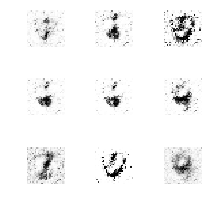

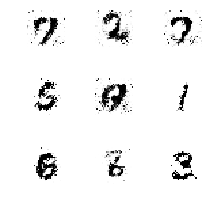

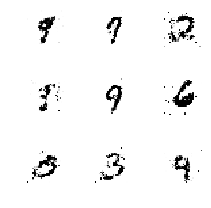

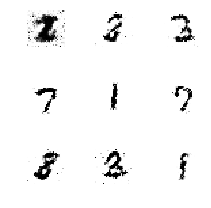

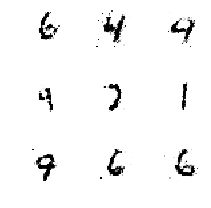

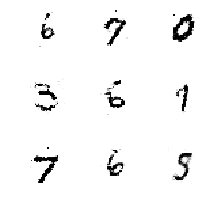

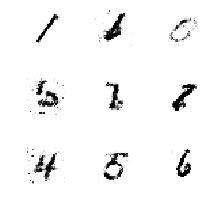

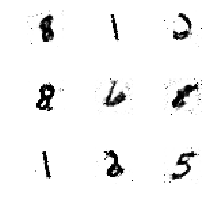

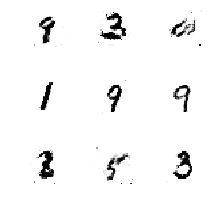

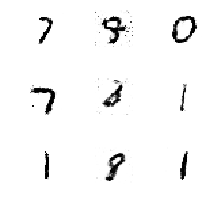

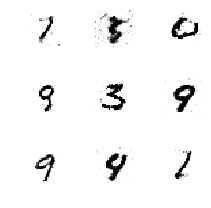

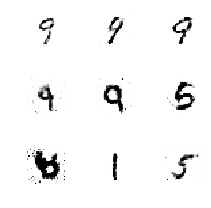

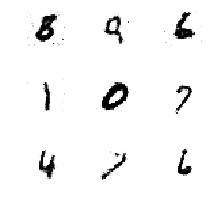

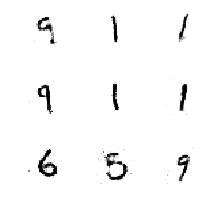

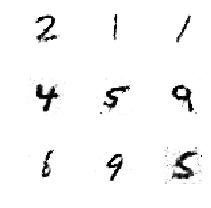

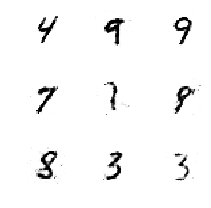

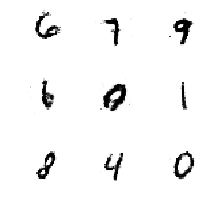

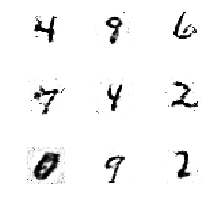

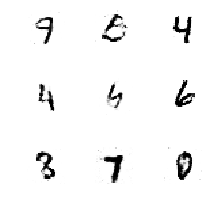

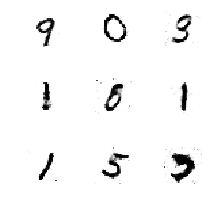

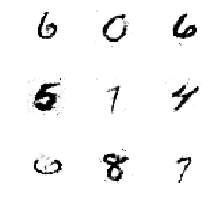

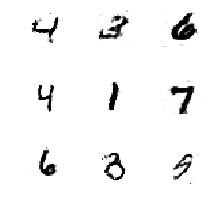

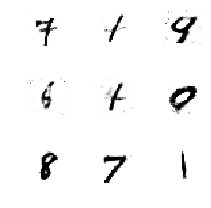

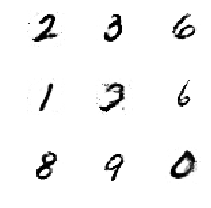

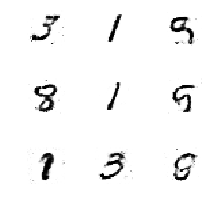

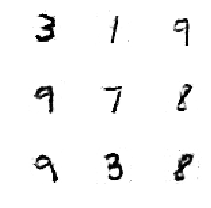

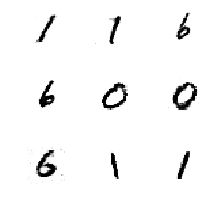

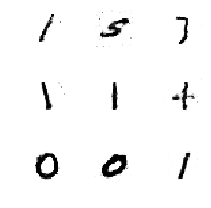

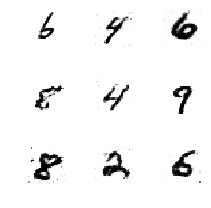

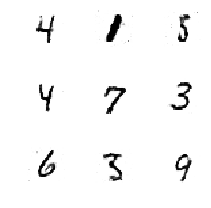

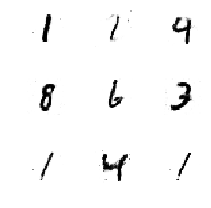

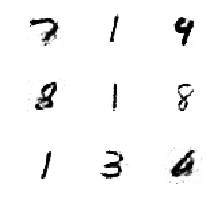

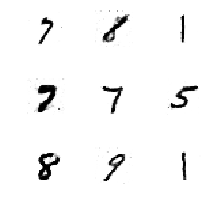

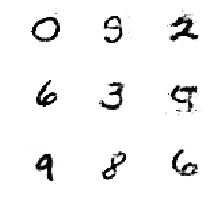

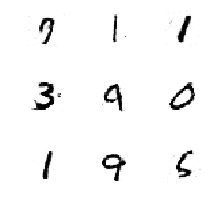

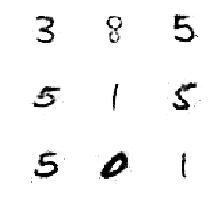

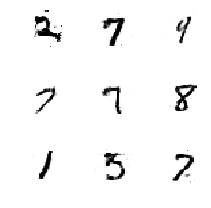

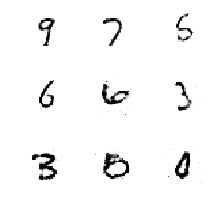

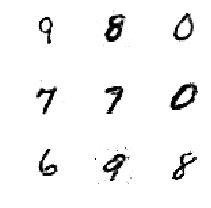

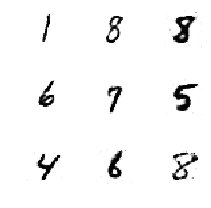

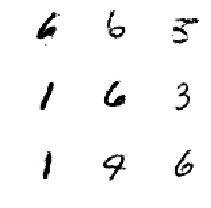

In [0]:
t1=time.time()
train( 200,128)
t2=time.time()
print(t2-t1)